In [1]:
from ast import literal_eval
from glob import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import XML2Dict

In [4]:
%matplotlib notebook

### Get file names

In [10]:
data_folder = r'E:\TC_testing\mouse000000\TCtest22_2023-01-10_15-54-43\experiment1\recording1'

settings_file = os.path.join(os.path.dirname(os.path.dirname(data_folder)), 'settings.xml')
structure_file = os.path.join(data_folder, 'structure.oebin')

data_file = sorted(glob(data_folder + '/**/continuous.dat', recursive=True))[0]
timestamp_file = sorted(glob(data_folder + '/**/timestamps.npy', recursive=True))[0]
# samplenum_file = sorted(glob(data_folder + '/**/sample_numbers.npy', recursive=True))[0]

#### Read messages

In [6]:
messages_file = sorted(glob(data_folder + '/**/text.npy', recursive=True))[0]
messages = np.load(messages_file)

In [7]:
messages

array([b'Same as test21, TC more in nostril now'], dtype='|S513')

In [8]:
messTS_file = sorted(glob(os.path.dirname(messages_file) + '/timestamps.npy', recursive=True))[0]
messTS = np.load(messTS_file)
print(messTS)

[600.4736]


In [9]:
messSN_file = sorted(glob(os.path.dirname(messages_file) + '/sample_numbers.npy', recursive=True))[0]
messSN = np.load(messSN_file)
print(messSN)

[1501184]


### Read structure.oebin file

In [11]:
Info = literal_eval(open(structure_file).read())
Rhythm_info = next((
    sub for sub in Info['continuous'] if sub['source_processor_name'] in ['Rhythm FPGA', 'Acquisition Board']), None)

In [12]:
Rhythm_info.keys()

dict_keys(['folder_name', 'sample_rate', 'source_processor_name', 'source_processor_id', 'stream_name', 'recorded_processor', 'recorded_processor_id', 'num_channels', 'channels'])

In [12]:
Rhythm_info['channels'][32]

{'channel_name': 'ADC1',
 'description': 'ADC input channel from a Rhythm FPGA device',
 'identifier': '',
 'history': 'Acquisition Board -> Record Node',
 'bit_volts': 0.000152587890625,
 'units': 'V'}

#### Extract metadata

In [13]:
sample_rate = int(Rhythm_info['sample_rate'])
num_chs = Rhythm_info['num_channels']

EEG_gain = Rhythm_info['channels'][0]['bit_volts'] # converts to microvolts
ADC_gain = Rhythm_info['channels'][32]['bit_volts'] # converts to volts

### Load data

In [14]:
raw_cont = np.memmap(data_file, dtype='int16', mode='r')
raw_cont = raw_cont.reshape((int(raw_cont.size/num_chs), num_chs))

timex = np.load(timestamp_file)

iso_signal = raw_cont[:, 32] * ADC_gain
TC1 = raw_cont[:, 33] * ADC_gain
TC2 = raw_cont[:, 34] * ADC_gain
emptych = raw_cont[:, 35] * ADC_gain

### Plot

<IPython.core.display.Javascript object>


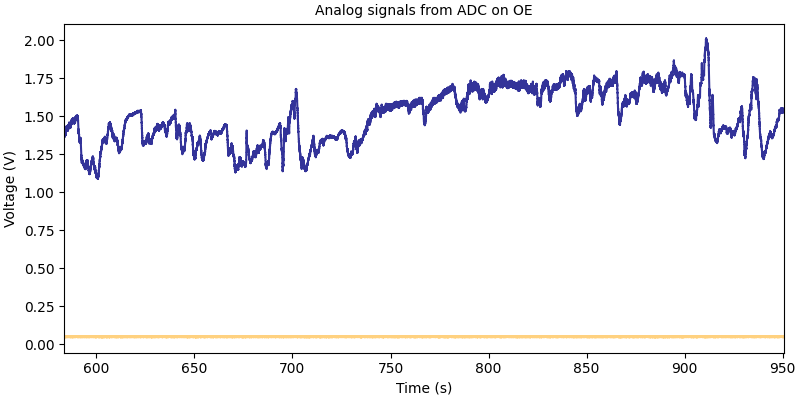

Text(0.5, 1.0, 'Analog signals from ADC on OE')

In [15]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

# ax.plot(timex, emptych, color='gray', alpha=0.5)
ax.plot(timex, iso_signal, color='orange', alpha=0.5)
ax.plot(timex, TC1, color='navy', alpha=0.8)
# ax.plot(timex, TC2, color='darkorchid', alpha=0.8)

ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Analog signals from ADC on OE')

Mouse respiratory rate should be ~1-6 Hz

### Do some signal processing

In [61]:
## Apply low-pass filter ##
# lpb, lpa = signal.butter(3, 100/(sample_rate/2), btype='low')
# TC1_lp100 = signal.filtfilt(lpb, lpa, TC1_TCcirc, axis=0)

# lpb, lpa = signal.butter(3, 50/(sample_rate/2), btype='low')
# TC1_lp50 = signal.filtfilt(lpb, lpa, TC1_TCcirc, axis=0)

lpb, lpa = signal.butter(3, np.array([1.0,20])/(sample_rate/2), btype='band')
TC1_lp20 = signal.filtfilt(lpb, lpa, TC1, axis=0)

<IPython.core.display.Javascript object>


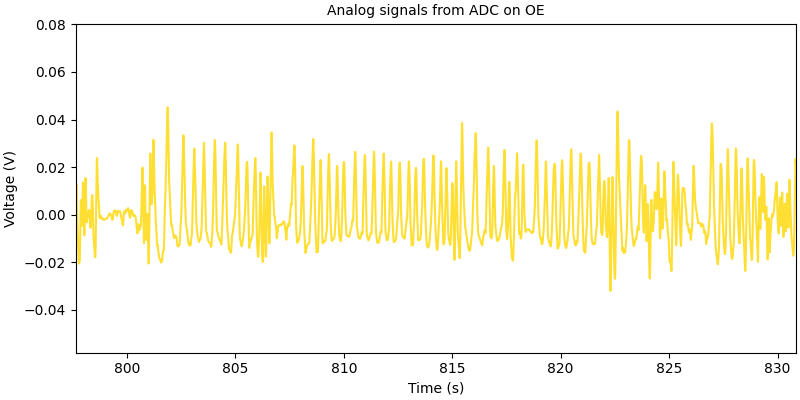

Text(0.5, 1.0, 'Analog signals from ADC on OE')

In [62]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

ax.plot(timex, TC1, color='navy', alpha=0.8)
# ax.plot(timex, TC1_lp100, color='m', alpha=0.8)
# ax.plot(timex, TC1_lp50, color='violet', alpha=0.8)
ax.plot(timex, TC1_lp20, color='gold', alpha=0.8)

ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Analog signals from ADC on OE')

### Power spectrum for TC signal

In [63]:
## Process the power spectrum across the whole recording ##
frex, Pxx = signal.welch(TC1_lp20, sample_rate, nperseg=2 * sample_rate, axis=0)

<IPython.core.display.Javascript object>


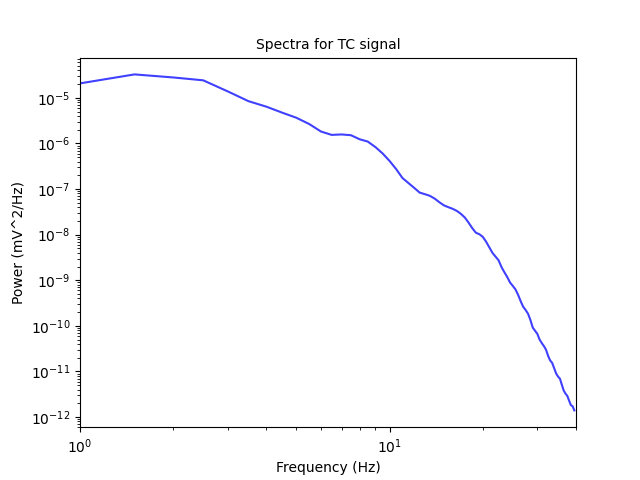

Text(0.5, 1.0, 'Spectra for TC signal')

In [64]:
frinds = frex < 40

fig, ax = plt.subplots()

ax.loglog(frex[frinds], Pxx[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([1, 40])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra for TC signal')

<IPython.core.display.Javascript object>


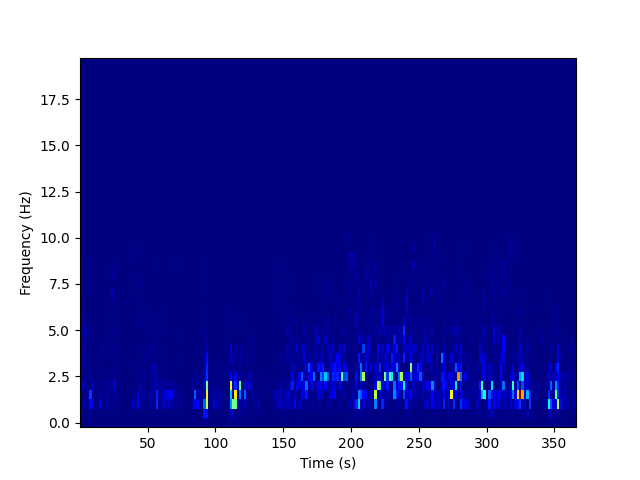

Text(0.5, 0, 'Time (s)')

In [65]:
f, t, Sxx = signal.spectrogram(TC1_lp20, sample_rate, nperseg=2 * sample_rate)
frix = f < 20

fig, ax = plt.subplots()
ax.pcolormesh(t, f[frix], Sxx[frix,:], cmap='jet', shading='auto')#, vmin=1E-3, vmax=0.01)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')

In [33]:
print(t.shape)
print(f.shape)
print(Sxx.shape)

(209,)
(2501,)
(2501, 209)


In [56]:
np.max(Sxx[frix,:])

0.0030101445219321093

## Analog iso signal from OpenEphys

exp.load_eegdata(): during preprocessing step cuts array down to 32 chs
<br>exp._memmap_EEGdata(): the memmap step re-orders the data via the intan eeg map which cuts the array down to 32 chs

In [6]:
print(exp.settings_file)

NameError: name 'exp' is not defined

In [9]:
# Can we use settings or structure.oebin to get the ch names/locations to ID "iso_level" in the analog signal list?
Settings = XML2Dict(exp.settings_file)

In [10]:
Settings.keys()

dict_keys(['INFO', 'SIGNALCHAIN', 'SIGNALCHAIN_2', 'AUDIO', 'GLOBAL_TIMESTAMP', 'CONTROLPANEL', 'AUDIOEDITOR', 'PROCESSORLIST', 'UICOMPONENT'])

In [11]:
try:
    FPGA_settings = Settings['SIGNALCHAIN']['PROCESSOR']['Sources/Rhythm FPGA']
except KeyError:
    FPGA_settings = Settings['SIGNALCHAIN_2']['PROCESSOR']['Sources/Rhythm FPGA']

try:
    iso_ind = int(FPGA_settings['CHANNEL_INFO']['CHANNEL']['iso_level']['number'])
    iso_gain = float(FPGA_settings['CHANNEL_INFO']['CHANNEL']['iso_level']['gain'])
except KeyError:
    iso_ind = int(FPGA_settings['CHANNEL_INFO']['CHANNEL']['ISO_LEVEL']['number'])
    iso_gain = float(FPGA_settings['CHANNEL_INFO']['CHANNEL']['ISO_LEVEL']['gain'])

In [12]:
print(FPGA_settings['CHANNEL_INFO']['CHANNEL'].keys())
print(iso_ind)

dict_keys(['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'CH17', 'CH18', 'CH19', 'CH20', 'CH21', 'CH22', 'CH23', 'CH24', 'CH25', 'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32', 'ISO_LEVEL', 'ADC2', 'ADC3', 'ADC4', 'ADC5', 'ADC6', 'ADC7', 'ADC8'])
32


In [13]:
ds_factor = int(exp.ephys_params['EEG']['sample_rate'] / TARGET_SAMPLE_RATE)
print(ds_factor)

25


In [14]:
raw_cont = np.memmap(exp.ephys_params['EEG']['continuous'], dtype='int16', mode='r')
print(raw_cont.shape)
print(raw_cont.shape[0] % exp.ephys_params['EEG']['num_chs'])

(98895112704,)
24


In [15]:
try:
    raw_cont = raw_cont.reshape((int(raw_cont.size/exp.ephys_params['EEG']['num_chs']), exp.ephys_params['EEG']['num_chs']))
except ValueError:
    desired_length = raw_cont.shape[0] - raw_cont.shape[0] % exp.ephys_params['EEG']['num_chs']
    raw_cont = raw_cont[:desired_length].reshape((int(desired_length/exp.ephys_params['EEG']['num_chs']), exp.ephys_params['EEG']['num_chs']))
    
print(raw_cont.shape)

(2472377817, 40)


In [16]:
iso_sig = raw_cont[0::ds_factor, 33] * iso_gain
# iso_sig = raw_cont[:, 33]
analogx = np.arange(0, len(iso_sig)) / TARGET_SAMPLE_RATE
print(len(iso_sig))

98895113


<IPython.core.display.Javascript object>


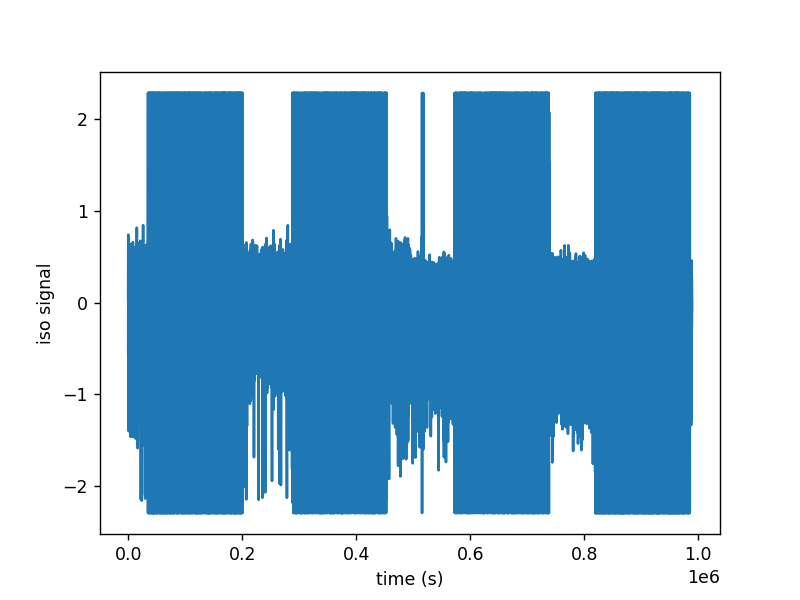

Text(0.5, 0, 'time (s)')

In [17]:
fig, ax = plt.subplots()
ax.plot(analogx, iso_sig*PER_VOLTS)
ax.set_ylabel('iso signal')
ax.set_xlabel('time (s)')

In [14]:
# make analog arrays into pandas Series
iso = pd.Series(data=iso_sig*PER_VOLTS, index=analogx, name='iso_level')
iso.head()

0.00    0.120356
0.01    0.126318
0.02    0.120356
0.03    0.131162
0.04    0.120356
Name: iso_level, dtype: float64

In [15]:
iso_max_times = (
    iso[iso > 4.9].index[0],
    iso[iso > 4.9].index[-1]
)
# iso_maint_times = (
#     iso[(iso > 1.8) & (iso < 2.2) & (iso.index > iso_max_times[1])].index[0],
#     iso[(iso > 1.8) & (iso < 2.2) & (iso.index > iso_max_times[1])].index[-1]
# )
iso_maint_times = (
    iso[(iso > 0.2) & (iso < 4.9) & (iso.index > iso_max_times[1])].index[0],
    iso[(iso > 0.2) & (iso < 4.9) & (iso.index > iso_max_times[1])].index[-1]
)
print(iso_max_times)
print(iso_maint_times)

(355.42, 1344.11)
(1344.12, 6461.46)


<IPython.core.display.Javascript object>


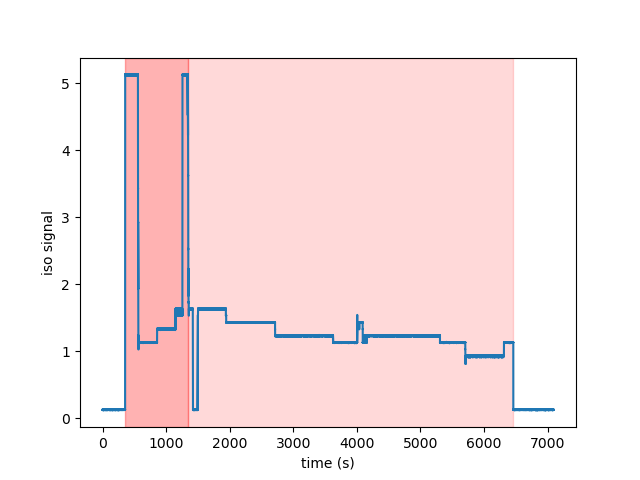

Text(0.5, 0, 'time (s)')

In [16]:
fig, ax = plt.subplots()
ax.plot(analogx, iso_sig*PER_VOLTS)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.3)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.15)
ax.set_ylabel('iso signal')
ax.set_xlabel('time (s)')